## Bayesian Inference

Bayes' rule is the following theorem about probability:

\begin{equation}
P(A|B) = \frac{P(B|A) P(A)}{P(B)}
\end{equation}

The notation $P(A|B)$ represents a **conditional probability**, that is, *the probability of A given B*.  Bayes' rule can be viewed as a way to update a **prior** probability $P(A)$ to a **posterior** probability given new information, $P(A|B)$.

In Bayesian inference, $A$ generally represents the parameters of the model (i.e. what we want to know) and $B$ represents the evidence (the data).  To continue the example from the last lesson, let $A$ be the mean profit per Eclair and  let $B$ be Art's measurements.

Let's remind ourselves what Art's data looks like:

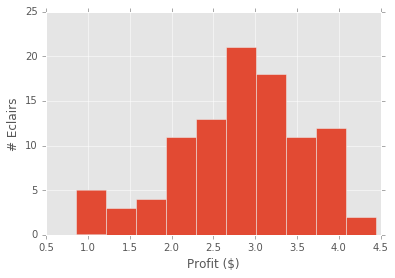

In [1]:
from numpy.random import seed
from scipy.stats import norm

#Model Art's measurements as a normally distributed random variate with prescribed mean and variance
true_mean = 2.82
true_variance = 0.56

seed(313)
data = norm.rvs(loc=true_mean, scale=true_variance**0.5, size=100)

%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('ggplot')

plt.figure()
_ = plt.hist(data)
_ = plt.ylabel('# Eclairs')
_ = plt.xlabel('Profit ($)')

##### Step 1: Choose the likelihood function

The first step in Bayesian inference is to choose $P(B|A)$.  Strictly speaking, this is not a probability but a **likelihood** that $B$ is to be observed given model $A$.  To simplify things a bit, we'll assume that Art knows that the variance $\sigma^2$ of the model is 0.56, so he is only after one model parameter, the mean $\mu$.  Art's data are normally distributed, so a logical choice for the likelihood of each data point is a normal distribution centered on $\mu$.  Since his data are independent, he can take the product of all his measurements to obtain the total likelihood:

\begin{equation}
P(B|A) = \prod_{x=1}^{n} {f_\mu(x_i)}
\end{equation}

where $x$ is the data vector with $n$ elements and $f_\mu$ is the probability density function for a normal distribution centered on $\mu$ with variance of 0.56.


##### Step 2: Choose the prior distribution

The second step is to choose the form of the prior distribution $P(A)$.  It turns out that Jesse had conducted a small pilot study a few weeks prior and found that the average profit was $3.10 \pm 0.40$ (2$\sigma$) dollars, so Art decides to use a normal distribution as his prior with $\mu_0 = 3.1$ and $\sigma_0 = 0.2$.

##### Step 3: Evaluate the denominator

The third step is to evaluate the denominator of Bayes' Rule, $P(B)$.  In theory this can be done by integrating the joint PDF over all possible values of the model:

\begin{equation}
P(B) = \int_A P(B,A) \, dA
\end{equation}

Only a small subset of cases exist where this integral is tractable, so in many real-world situations numerical sampling is performed to estimate the posterior distribution.  In this case, however, we have an example of a **conjugate prior** where the prior and posterior distributions belong to the same family.  Instead of going through the math each time I encounter an example of conjugate priors, I consult a useful table of rules for conjugate priors that can be found [here](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).  You'll find that for Art's example, the posterior distribution is normal with mean and variance given by

\begin{eqnarray}
\mu    =& \frac{1}{\frac{1}{\sigma^2_0} + \frac{n}{\sigma^2}} \left( \frac{\mu_0}{\sigma^2_0}  +  \frac{\sum_{i=1}^n x_i}{\sigma^2} \right) \\
\sigma^2 =& \left( \frac{1}{\sigma^2_0} + \frac{n}{\sigma^2}  \right)^{-1}
\end{eqnarray}

where $x$ is the data vector and $n$ is the number of observations.  Let's plot the prior and posterior probability distribution functions.

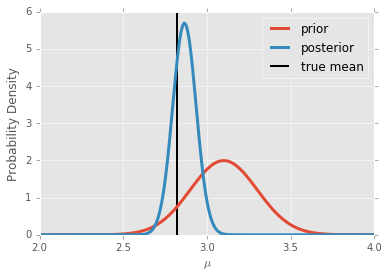

In [2]:
from numpy import linspace

#Set Art's prior
mu_prior = 3.10
sigma_prior = 0.20

#This is sigma for the likelihood function, P(B|A)
sigma = true_variance**0.5
n = len(data)
mu_posterior = (mu_prior / sigma_prior**2 + sum(data) / sigma**2) / (1. / sigma_prior**2 + n / sigma**2)
variance_posterior = (1. / sigma_prior**2 + n / sigma**2)**-1

x = linspace(2, 4, 200)

prior     = norm(mu_prior, sigma_prior).pdf(x)
posterior = norm(mu_posterior, variance_posterior**0.5).pdf(x)

_ = plt.plot(x, prior, label = 'prior', lw=3)
_ = plt.plot(x, posterior, label = 'posterior', lw=3)
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Probability Density')
_ = plt.axvline(true_mean,color='k',lw=2,label = "true mean",zorder=1)
_ = plt.legend()

Through Bayes' rule, Art's measurements have updated his priors and have resulted in a new, tighter distribution with a mean closer to the true value.  Notice that the mean of the posterior distribution is greater than the true mean; this is a direct result of Art's chosen prior.  If Art's priors are well informed, this illustrates a clear advantage of the Bayesian approach.  His result will be closer to the truth because he took prior information into account.  However, if Art's priors are ill-founded---as they are in this example---his result will be further from the truth.  One common criticism of the Bayesian approach is that the priors can be tuned to achieve a desired result.


#### Sampling the posterior distribution

Now let's write some code blocks to estimate the posterior distribution numerically.  We will be using a technique called **Monte Carlo Markov Chain (MCMC)** to do so.  In essence, this method works by following a sampler as it takes random steps through model space.  If a proposed step happens to take the sampler in a favorable direction, the step will be accepted, but if the proposal takes the sample in an unfavorable direction, the step may be rejected.  The probability that an unfavorable step should be accepted is equal to $P_{proposed} / P_{current}$.  Allowing *some* unfavorable steps is crucial for sampling the tails of the distribution, but using this ratio in particular as the acceptance criterion allows us to sample the posterior distribution without having to worry about the denominator of Bayes' theorem.  

From this principle, the sampler will take more steps in regions of high probability and fewer steps in lower probability regions.

The first piece of our code will propose a random step.  There are many ways to do this, but let's make it simple.  The new value of $\mu$ will be drawn from a normal distribution centered on the current value with a width of 0.05.

In [3]:
def propose_new_step(mu_0):
    #Step in a random direction around the current value according to a normal distribution
    mu_new = norm.rvs(loc=mu_0, scale=0.05,size=1)[0]
    
    #Compute likelihoods for both points
    #  Art's measurements are iid so we can simply take their product
    #
    likelihood_0   = norm(mu_0,   sigma).pdf(data).prod()
    likelihood_new = norm(mu_new, sigma).pdf(data).prod()
    
    #Compute prior probability for both points
    prior_0   = norm(mu_prior, sigma_prior).pdf(mu_0)
    prior_new = norm(mu_prior, sigma_prior).pdf(mu_new)
    
    #Compute posterior probability for both points (denominator cancels out!)
    p_0   = likelihood_0   * prior_0
    p_new = likelihood_new * prior_new
    
    #Return new model parameter and acceptance criterion
    return mu_new, p_new/p_0

Now we write a routine that initializes $\mu$ and loops over thousands of steps, accepting each with a probability according to what was discussed above. 

In [4]:
def run_mcmc(nsteps=3000):
    from numpy.random import rand
    
    mu_cur = 3.0 #Pick intelligent starting value
    
    #init list to collect samples
    samples=[]
    
    seed(17)
    for istep in range(nsteps):
        mu_new, acceptance = propose_new_step(mu_cur)
        
        if acceptance > rand():
            mu_cur = mu_new  #Accept step
        else:
            pass  #no change
        
        samples.append(mu_cur)
    
    return samples

Now let's run three iterations of our MCMC algorithm as the number of steps is increased, the sample distribution converges towards the analytical solution.

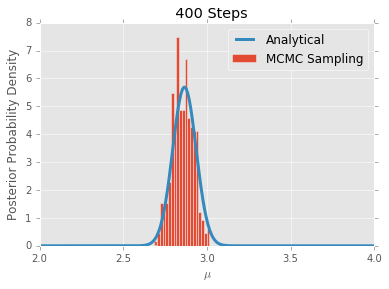

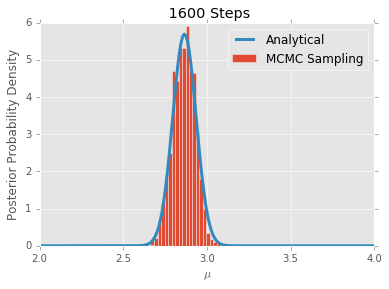

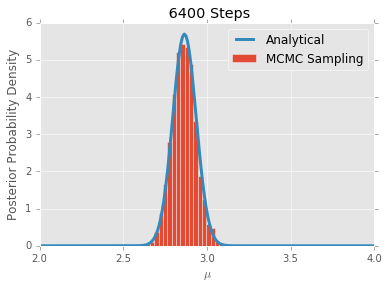

In [5]:
for nsteps in [400,1600,6400]:
    samples = run_mcmc(nsteps=nsteps)
    _ = plt.figure()
    _ = plt.hist(samples, normed = True, bins = 20, label = 'MCMC Sampling')
    _ = plt.plot(x, posterior, lw=3, label = 'Analytical')
    _ = plt.legend(fancybox = True)
    _ = plt.title('%5d Steps' % nsteps)
    _ = plt.ylabel("Posterior Probability Density")
    _ = plt.xlabel("$\mu$")

This is great.  We have two ways to calculate to posterior distribution, but what do we do with it?  The question remains, what are the chances that the mean profit per eclair is less than $2.93?  One of the nice things about MCMC is that the collection of returned samples need not follow an orderly distribution.  It might not seem like much in this simple example with conjugate distributions, but it is a clear advantage when dealing with multi-parameter models or with non-normally distributed data.

We can just estimate this probability by counting the fraction of samples that meet the criteria:

In [7]:
from numpy import array
samples = array(samples)

p = len(samples [ samples < 2.93 ] ) / len(samples)
print('Probability = %2d' % (p*100) + '%')

Probability = 84%


Recall that the $p$-value of the $t$-test was about 10%, corresponding to a probability of 90%.  The loss of 6% in this example was caused by Art's prior.